In [1]:
%matplotlib inline
from scipy.stats import kurtosis, skew
from timedisagg.td import TempDisagg
import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

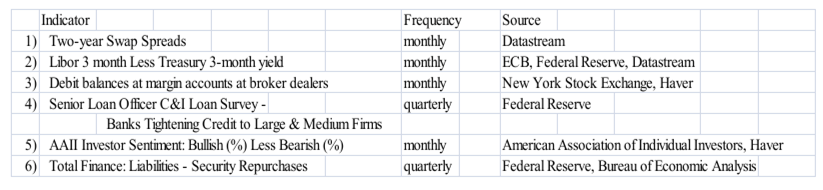

## 1. Two-year Swap Spreads

In [2]:
# Import data from 2 sources for get all data in period 2014 to 2019

# Get 2 years swap rate first period
SWP_old = data.DataReader('DSWP2', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2014, 7, 31))
# Create column name
SWP_old.columns = ['2_yrs_swap_rate']

# Get 2 years swap rate second period
SWP_new = data.DataReader('ICERATES1100USD2Y', 'fred', datetime.datetime(2014, 8, 1), datetime.datetime(2019, 12, 31))
# Create column name (same as SWP_old)
SWP_new.columns = ['2_yrs_swap_rate']

# Combine 2 years swap rate of 2 periods
_2yrs_swap_rate = SWP_old.append(SWP_new)

# Get 2 years tbill yield
_2yrs_tbill = data.DataReader('DGS2', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2019, 12, 31))
# Create column name
_2yrs_tbill.columns = ['2_yrs_treasury_yield']

# Calculte 2 years swap spread
_2yrs_swap_spread_daily = pd.DataFrame(_2yrs_swap_rate.values - _2yrs_tbill.values, 
                                 index = _2yrs_swap_rate.index, columns = ['2_yrs_swap_spread'])

# deal with missing value
_2yrs_swap_spread_daily = _2yrs_swap_spread_daily.interpolate().fillna(method = 'bfill')

# Monthly 2 years swap spread
_2yrs_swap_spread_daily = _2yrs_swap_spread_daily.reset_index()
_2yrs_swap_spread_daily.DATE = pd.to_datetime(_2yrs_swap_spread_daily.DATE)
_2yrs_swap_spread = _2yrs_swap_spread_daily.resample('M', on = 'DATE').mean()
_2yrs_swap_spread = _2yrs_swap_spread[['2_yrs_swap_spread']]
_2yrs_swap_spread

,2_yrs_swap_spread
DATE,
2014-01-31,0.107609
2014-02-28,0.121000
2014-03-31,0.119048
2014-04-30,0.118864
2014-05-31,0.129091
...,...
2019-08-31,0.004227
2019-09-30,-0.005571
2019-10-31,0.032239


In [3]:
# Check data
_2yrs_swap_spread.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-31 to 2019-12-31
Freq: M
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   2_yrs_swap_spread  72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


## 2. Libor 3 month Less Treasury 3 month  yield

In [4]:
# import Libor 3 month Less Treasury 3 month  yield ==> TED
TED_spread_daily = data.DataReader('TEDRATE', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2019, 12, 31))
# Create column name
TED_spread_daily.columns = ['3M LIBOR - 3M TBILL']

# Deal with missing value
TED_spread_daily = TED_spread_daily.interpolate().fillna(method = 'bfill')

# Daily to Monthly 
TED_spread_daily = TED_spread_daily.reset_index()
TED_spread_daily.DATE = pd.to_datetime(TED_spread_daily.DATE)
TED_spread = TED_spread_daily.resample('M', on = 'DATE').mean()
TED_spread = TED_spread[['3M LIBOR - 3M TBILL']]
TED_spread

,3M LIBOR - 3M TBILL
DATE,
2014-01-31,0.195435
2014-02-28,0.184000
2014-03-31,0.180000
2014-04-30,0.198636
2014-05-31,0.193864
...,...
2019-08-31,0.215227
2019-09-30,0.228571
2019-10-31,0.331087


In [5]:
# Check data
TED_spread.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-31 to 2019-12-31
Freq: M
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   3M LIBOR - 3M TBILL  72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


##  3. Debit balances at margin account at broker dealer

In [6]:
# Import data
debit_balance = pd.read_excel('https://www.finra.org/sites/default/files/2021-03/margin-statistics.xlsx', 
                              index_col = 'Year-Month', parse_dates = True)
# select column and sort date
debit_balance = debit_balance[["Debit Balances in Customers' Securities Margin Accounts"]].sort_index()
# Create column name
debit_balance.columns = ['debit_balance']
# select period that we wil use
debit_balance = debit_balance['2014-01-01' : '2019-12-31']
debit_balance

,debit_balance
Year-Month,
2014-01-01,487549
2014-02-01,502093
2014-03-01,487932
2014-04-01,475195
2014-05-01,475362
...,...
2019-08-01,564894
2019-09-01,555910
2019-10-01,554604


In [7]:
# Check data
debit_balance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   debit_balance  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


##  4. AAII Investors Sentiment Bullish (%) less Bearish (%)

In [8]:
# import data

# Select User-Agent from http://www.useragentstring.com/pages/useragentstring.php
hdr = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
# url for import data
reg_url = 'https://www.aaii.com/files/surveys/sentiment.xls'
# request data
resp = requests.get(reg_url, headers = hdr).content
# importdata
investor_sentiment = pd.read_excel(resp, usecols=[0, 1, 3, 6], names=['Date', 'Bull', 'Bear', 'Bull - Bear'],
                                   index_col = 'Date' , parse_dates = True)
# Set datetime 
investor_sentiment = investor_sentiment['1987-06-26 00:00:00' : '2021-08-12 00:00:00'] # know from investor_sentiment.index
investor_sentiment_biweekly = investor_sentiment.reset_index()
investor_sentiment_biweekly.Date = pd.to_datetime(investor_sentiment_biweekly.Date)

# Deal with missing value
investor_sentiment_biweekly = investor_sentiment_biweekly.interpolate().fillna(method = 'bfill')

# change Biweekly to Monthly
investor_sentiment = investor_sentiment_biweekly.resample('M', on = 'Date').mean()
# select only this column
investor_sentiment = investor_sentiment[['Bull - Bear']] 
# select period that we wil use
investor_sentiment = investor_sentiment[datetime.datetime(2014, 1, 1) : datetime.datetime(2020, 1, 1)]
investor_sentiment

,Bull - Bear
Date,
2014-01-31,0.127461
2014-02-28,0.105635
2014-03-31,0.103970
2014-04-30,0.010970
2014-05-31,0.055623
...,...
2019-08-31,-0.126005
2019-09-30,-0.013395
2019-10-31,-0.052561


In [9]:
# Check data
investor_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-31 to 2019-12-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Bull - Bear  72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


## 5. Senior Loan Officers C&I loan survey – Bank tightening Credit to Large and Medium Firms

In [10]:
# Import Senior Loan Officers C&I loan survey – Bank tightening Credit to Large and Medium Firms
loan_survey = data.DataReader('DRTSCILM', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1))
# Crate column name
loan_survey.columns = ['Senior Loan Officers C&I loan survey']

# Set datetime 
loan_survey = loan_survey.reset_index()
loan_survey['DATE'] = pd.to_datetime(loan_survey['DATE']).dt.to_period('M')

# Change to monthly
loan_survey = loan_survey.set_index('DATE').resample('M').interpolate()
loan_survey = loan_survey[datetime.datetime(2014, 1, 1) : datetime.datetime(2019, 12, 31)]
loan_survey

,Senior Loan Officers C&I loan survey
DATE,
2014-01,-13.700000
2014-02,-12.833333
2014-03,-11.966667
2014-04,-11.100000
2014-05,-10.966667
...,...
2019-08,-0.066667
2019-09,2.666667
2019-10,5.400000


In [11]:
# check data
loan_survey.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 72 entries, 2014-01 to 2019-12
Freq: M
Data columns (total 1 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Senior Loan Officers C&I loan survey  72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


## 6. Total Finance: Liabilities – Security Repurchase

In [12]:
# Import Total Finance: Liabilities – Security Repurchase
sec_repo = data.DataReader('FBLSRAQ027S', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1))
# Create column name
sec_repo.columns = ['Security_Repurchase']

# Set datetime
sec_repo = sec_repo.reset_index()
sec_repo['DATE'] = pd.to_datetime(sec_repo['DATE']).dt.to_period('M')

# change to monthly
sec_repo = sec_repo.set_index('DATE').resample('M').interpolate()
sec_repo = sec_repo[datetime.datetime(2014, 1, 1) : datetime.datetime(2019, 12, 31)]
sec_repo

,Security_Repurchase
DATE,
2014-01,4.848053e+06
2014-02,4.895415e+06
2014-03,4.942777e+06
2014-04,4.990139e+06
2014-05,4.966208e+06
...,...
2019-08,5.410265e+06
2019-09,5.369302e+06
2019-10,5.328340e+06


In [13]:
# check data
sec_repo.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 72 entries, 2014-01 to 2019-12
Freq: M
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Security_Repurchase  72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


### Combine 6 indicator above in one dataframe and array

In [14]:
# Place the DataFrames side by side

# comnine 6 indicator as array
LCI_component_array = np.hstack((_2yrs_swap_spread.values, 
                           TED_spread.values, 
                           debit_balance.values, 
                           investor_sentiment.values, 
                           loan_survey.values, 
                           sec_repo.values))
# Create column name
columns=['_2yrs_swap_spread', 'TED_spread', 'debit_balance', 'investor_sentiment', 'loan_survey', 'sec_repo']

# comnined 6 indicator as df
LCI_component_df = pd.DataFrame(LCI_component_array, index=sec_repo.index, columns=columns)
LCI_component_df

,_2yrs_swap_spread,TED_spread,debit_balance,investor_sentiment,loan_survey,sec_repo
DATE,,,,,,
2014-01,0.107609,0.195435,487549.0,0.127461,-13.700000,4.848053e+06
2014-02,0.121000,0.184000,502093.0,0.105635,-12.833333,4.895415e+06
2014-03,0.119048,0.180000,487932.0,0.103970,-11.966667,4.942777e+06
2014-04,0.118864,0.198636,475195.0,0.010970,-11.100000,4.990139e+06
2014-05,0.129091,0.193864,475362.0,0.055623,-10.966667,4.966208e+06
...,...,...,...,...,...,...
2019-08,0.004227,0.215227,564894.0,-0.126005,-0.066667,5.410265e+06
2019-09,-0.005571,0.228571,555910.0,-0.013395,2.666667,5.369302e+06
2019-10,0.032239,0.331087,554604.0,-0.052561,5.400000,5.328340e+06


In [15]:
# Check data
LCI_component_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 72 entries, 2014-01 to 2019-12
Freq: M
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _2yrs_swap_spread   72 non-null     float64
 1   TED_spread          72 non-null     float64
 2   debit_balance       72 non-null     float64
 3   investor_sentiment  72 non-null     float64
 4   loan_survey         72 non-null     float64
 5   sec_repo            72 non-null     float64
dtypes: float64(6)
memory usage: 3.9 KB


In [16]:
# Instantiate and fit PCA model

# Scale data
scaler1 = StandardScaler()
LCI_component_standardized = scaler1.fit_transform(LCI_component_df)

# PCA for finding PCA components
pca6 = PCA(n_components=6)
PCA6_scores_array = pca6.fit_transform(LCI_component_standardized)
PCA6_scores_df = pd.DataFrame(PCA6_scores_array, index = sec_repo.index, 
                              columns = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6'])
PCA6_scores_df

,C_1,C_2,C_3,C_4,C_5,C_6
DATE,,,,,,
2014-01,1.004200,-2.263240,-0.664737,-0.432120,0.357231,0.808206
2014-02,0.909337,-2.031447,-0.398416,-0.544945,0.190727,0.562008
2014-03,0.651044,-2.112319,-0.390186,-0.433107,-0.048848,0.627497
2014-04,-0.006910,-1.756896,-0.451217,-1.040495,-0.320697,0.777271
2014-05,0.286091,-1.883126,-0.555958,-0.706066,-0.293649,0.681384
...,...,...,...,...,...,...
2019-08,-2.488596,-0.598858,1.957410,-1.087135,0.110826,0.117114
2019-09,-2.254361,-0.957595,1.647373,-0.028660,0.424024,0.026437
2019-10,-2.456761,0.031153,0.977843,-0.042561,0.518981,0.115112


## Leading Credit Index (LCI)

In [17]:
# Select 1st component for being a LCI
LCI_index = PCA6_scores_df[['C_1']]
# Create column name
LCI_index.columns = ['LCI_index']
LCI_index

,LCI_index
DATE,
2014-01,1.004200
2014-02,0.909337
2014-03,0.651044
2014-04,-0.006910
2014-05,0.286091
...,...
2019-08,-2.488596
2019-09,-2.254361
2019-10,-2.456761


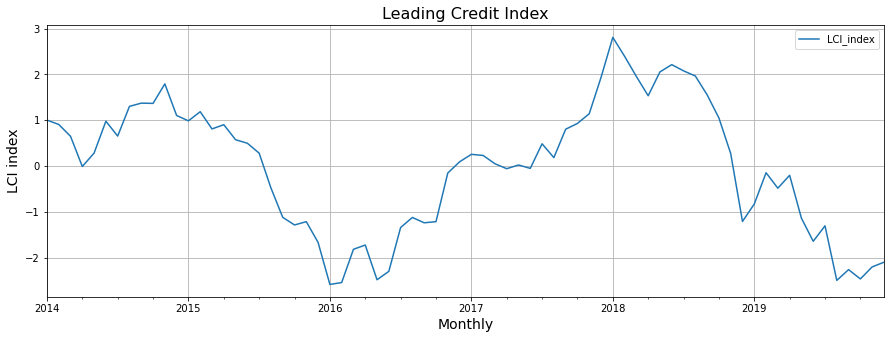

In [18]:
# Plot graph
LCI_index.plot(label = 'Leading Credit Index', figsize = (15,5))
plt.legend(loc='best')
plt.title('Leading Credit Index',fontsize=16)
plt.ylabel('LCI index', fontsize=14)
plt.xlabel('Monthly', fontsize=14)
plt.grid()